# Vehicle Detection and Tracking

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label as label_heatmap

import os
import time
import pickle

%matplotlib inline

## Load Data

In [2]:
test_images = [mpimg.imread('test_images/' + file) for file in os.listdir('test_images')]

In [3]:
# These are all 64x64 png images

vehicles_folders = ['data/vehicles/GTI_Far/', 'data/vehicles/GTI_Left/', 'data/vehicles/GTI_MiddleClose/', 'data/vehicles/GTI_Right/', 'data/vehicles/KITTI_extracted/']
nonvehicles_folders = ['data/non-vehicles/Extras/', 'data/non-vehicles/GTI/']

udacity_vehicles = [mpimg.imread(folder + file) for folder in vehicles_folders for file in os.listdir(folder)]
udacity_non_vehicles = [mpimg.imread(folder + file) for folder in nonvehicles_folders for file in os.listdir(folder)]

udacity_features_raw = np.concatenate((udacity_vehicles, udacity_non_vehicles))

## Train SVM

In [418]:
def feature_pipeline(image, feature_vector=True, gamma=True):
    cells_per_block = (2,2)
    pixels_per_cell = (8,8)
    orientations= 7
    
    image = cv2.resize(image, (64, 64))
        
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    ch0 = yuv[:,:,0]
    ch1 = yuv[:,:,1]
    ch2 = yuv[:,:,2]
    ch0_features = hog(ch0, orientations, pixels_per_cell, cells_per_block, transform_sqrt=gamma)
    ch1_features = hog(ch1, orientations, pixels_per_cell, cells_per_block, transform_sqrt=gamma)
    ch2_features = hog(ch2, orientations, pixels_per_cell, cells_per_block, transform_sqrt=gamma)
    hog_features = np.concatenate((ch0_features, ch1_features, ch2_features))
    
    rhist, _ = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist, _ = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist, _ = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    color_hist_features = np.concatenate((rhist, ghist, bhist))

    spatial_features = cv2.resize(image, (32, 32))
#     spatial_features = np.array([])
    
    features = np.concatenate((hog_features.ravel(), color_hist_features.ravel(), spatial_features.ravel()))

    return features

In [393]:
feature_pipeline(udacity_features_raw[0]).shape

(4212,)

In [419]:
loadfile = True
filename = "pickles/{0}cpb_{1}ppc_{2}o_{3}_gamma.p".format(2,8,7,'ycrcb_hist_32spat')

start = time.time()

if loadfile:
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    udacity_features = data['features']
    udacity_labels = data['labels']
    
else:
    udacity_features = [feature_pipeline(image) for image in udacity_features_raw]
    udacity_labels = np.concatenate((np.ones(len(udacity_vehicles)), np.zeros(len(udacity_non_vehicles))))
    
    with open(filename, 'wb') as f:
        pickle.dump({'features': udacity_features, 'labels': udacity_labels }, f)
        
scaler = StandardScaler()
scaler.fit(udacity_features)
udacity_features_scaled = scaler.transform(udacity_features)


end = time.time()

print('Runtime (s):', end - start)

Runtime (s): 7.254725933074951


In [420]:
start = time.time()

split_index = int(len(udacity_features_scaled) * .8)
X_train = udacity_features_scaled[0: split_index]
X_test = udacity_features_scaled[split_index:]
y_train = udacity_labels[0:split_index]
y_test = udacity_labels[split_index:]
# X_train, X_test, y_train, y_test = train_test_split(udacity_features_scaled, udacity_labels)

svc = LinearSVC(C=3e-7)
svc.fit(X_train, y_train)

train_accuracy = svc.score(X_train, y_train)
val_accuracy = svc.score(X_test, y_test)

end = time.time()

print('Train Accuracy: ', train_accuracy)
print('Val Accuracy: ', val_accuracy)
print('Model runtime (s):', end - start)

Train Accuracy:  0.951646959459
Val Accuracy:  0.975225225225
Model runtime (s): 6.615182161331177


## Pipeline

In [441]:
def pipeline(image, boxes=False):
    global heatmap
    draw_image = np.copy(image)
    search_spaces = [(400, 600, 115, 50), (400, 550, 90, 45)] # (360, 720, 140, 70), 
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]
    local_heatmap = np.zeros((720, 1280))
    
    for color, space in zip(colors, search_spaces):
        windows = sliding_windows(*space)
        window_images = [image[y1:y2,x1:x2][np.newaxis, ...] for x1,y1,x2,y2 in windows]
        window_images = np.concatenate(window_images, axis=0)
        features = [feature_pipeline(window_image)[np.newaxis,...] for window_image in window_images]
        features = np.concatenate(features)
    
        features_scaled = scaler.transform(features)
        pred = svc.predict(features_scaled)   
        
        for window, guess in zip(windows, pred):
            if guess == 1:
                if boxes:
                    cv2.rectangle(draw_image, (window[0], window[1]), (window[2], window[3]), color, 5)
                else:
                    local_heatmap[window[1]:window[3], window[0]:window[2]] += 1
 
        
    if not boxes:
        heatmap = .8 * heatmap + .2 * local_heatmap
        thresholded = heatmap > .3
        car_labels = label_heatmap(thresholded)
        for i in range(car_labels[1]):
            indexes = (car_labels[0] == i+1).nonzero()
            upperLeft = (np.min(indexes[1]), np.min(indexes[0]))
            lowerRight = (np.max(indexes[1]), np.max(indexes[0]))
            cv2.rectangle(draw_image, upperLeft, lowerRight, (255, 0, 0), 5)
    
    return draw_image
    

def sliding_windows(ystart, ystop, size, step, shape=(720, 1280)):
    xstart = 750
    return [(x,y, x+size, y+size) for y in range(ystart, ystop - size, step) for x in range(xstart, shape[1] - size, step)]

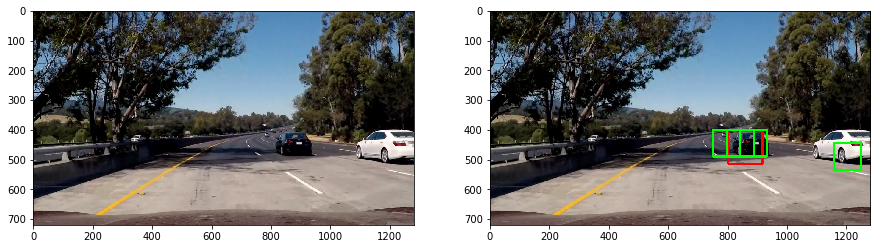

In [442]:
for image in test_images:
    heatmap = np.zeros((720, 1280))
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    processed = pipeline(image, boxes=True)
    plt.imshow(processed)
    break

## Video

In [446]:
heatmap = np.zeros((720, 1280))
clip = VideoFileClip('project_video.mp4') #(8,15), (14,16) 
processed_vid = clip.fl_image(pipeline)
%time processed_vid.write_videofile('processed_video.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


100%|█████████▉| 1260/1261 [06:03<00:00,  2.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 8min 12s, sys: 14min 53s, total: 23min 6s
Wall time: 6min 4s


In [447]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))